In [ ]:
### STOCK PRICE PREDICTION USING LSTM
# Author: Saarthak Srivastava
# Keras and Tensorflow 2.3

In [1578]:
# Data Collection
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd
# We can add any stock to get desired ticker live data
stock='^BSESN'
today = date.today()
# We can get data by our choice by giving days bracket
start_date= '2017-06-01'
files=[]
print (stock)
data = pdr.get_data_yahoo(stock, start=start_date, end=today)
dataname= stock+'_'+str(today)
files.append(dataname)
# Create a data folder in your current dir.
data.to_csv('./data/'+dataname+'.csv')
df= pd.read_csv('./data/'+ str(files[0])+'.csv')
df1=df.reset_index()['Close']

^BSESN
[*********************100%***********************]  1 of 1 completed


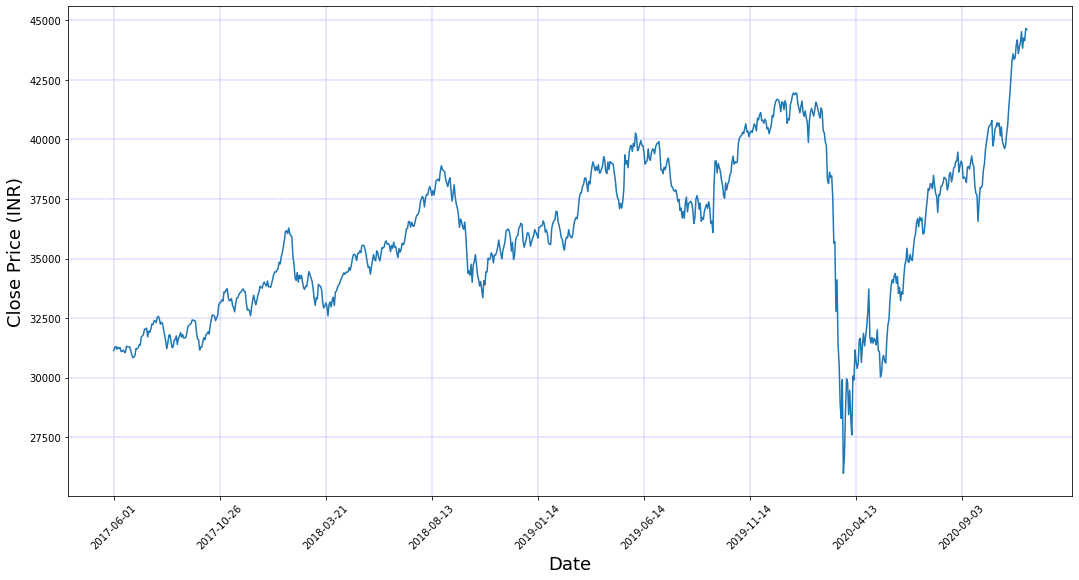

In [1579]:
# Plotting historical chart
import matplotlib.pyplot as plt
plt.figure(figsize = (18,9))
plt.plot(range(df1.shape[0]),(df1))
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [1581]:
# LSTMs are very sensetive to scale of data so we'll apply MinMax Scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [1582]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [1583]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----49   50 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [1584]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [1585]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 50, 50)            10400     
_________________________________________________________________
lstm_128 (LSTM)              (None, 50, 50)            20200     
_________________________________________________________________
lstm_129 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [1586]:
# Training the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
18/18 [==============================] - 1s 77ms/step - loss: 0.0517 - val_loss: 0.0320
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0.0233
Epoch 3/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0036 - val_loss: 0.0193
Epoch 4/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0028 - val_loss: 0.0175
Epoch 5/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0168
Epoch 6/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0159
Epoch 7/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0154
Epoch 8/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0148
Epoch 9/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0019 - val_loss: 0.0142
Epoch 10/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0130

18/18 [==============================] - 0s 21ms/step - loss: 3.5627e-04 - val_loss: 0.0017
Epoch 81/100
18/18 [==============================] - 0s 22ms/step - loss: 3.6048e-04 - val_loss: 0.0019
Epoch 82/100
18/18 [==============================] - 0s 20ms/step - loss: 4.8571e-04 - val_loss: 0.0019
Epoch 83/100
18/18 [==============================] - 0s 21ms/step - loss: 3.8178e-04 - val_loss: 0.0018
Epoch 84/100
18/18 [==============================] - 0s 20ms/step - loss: 4.8016e-04 - val_loss: 0.0018
Epoch 85/100
18/18 [==============================] - 0s 21ms/step - loss: 3.6260e-04 - val_loss: 0.0020
Epoch 86/100
18/18 [==============================] - 0s 22ms/step - loss: 3.5275e-04 - val_loss: 0.0017
Epoch 87/100
18/18 [==============================] - 0s 20ms/step - loss: 3.1602e-04 - val_loss: 0.0018
Epoch 88/100
18/18 [==============================] - 0s 20ms/step - loss: 3.4776e-04 - val_loss: 0.0019
Epoch 89/100
18/18 [==============================] - 0s 22ms/step -

In [1595]:
### Lets Do the prediction
import tensorflow as tf
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [1596]:
##Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

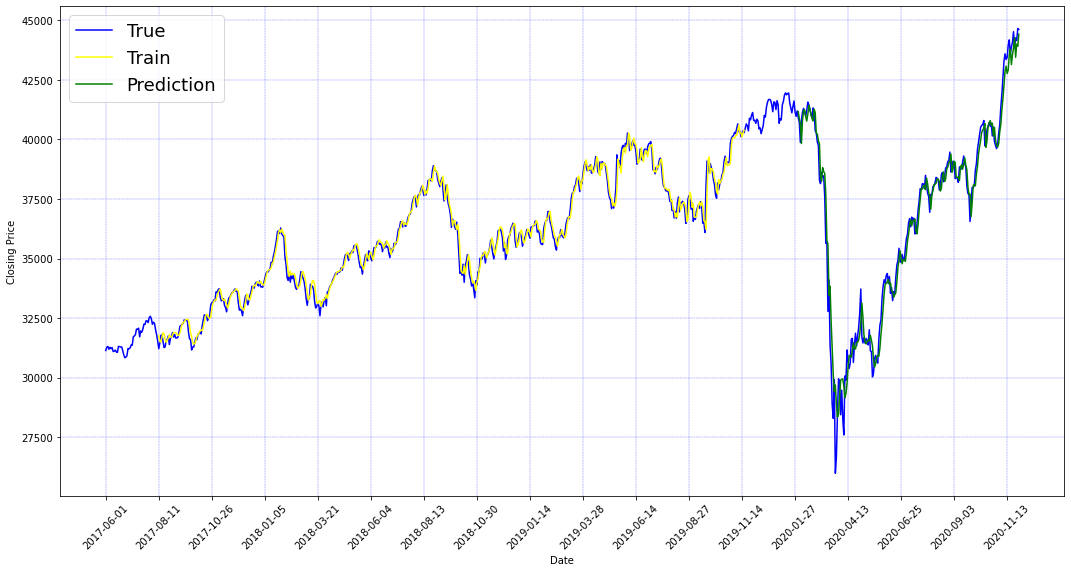

In [1597]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(df1), :] = test_predict
# plot baseline and predictions
plt.figure(figsize = (18,9))
plt.plot(scaler.inverse_transform(df1),color='b',label='True')
plt.plot(trainPredictPlot,color='yellow',label='Train')
plt.plot(testPredictPlot,color='green', label='Prediction')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(fontsize=18)
plt.show()

In [1598]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)

In [1599]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp2_input=temp_input

In [1600]:
# demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        mult=temp2_input[-1]/yhat[0]
        if(i%3==0):
            temp_input.extend((yhat[0])*mult.tolist())
        elif(i%10==0):
            temp_input.extend((yhat[0]).tolist())
        else:
            temp_input.extend(np.array([temp_input[-1]]).tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i+=1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        mult=temp2_input[-1]/yhat[0]
        temp_input.extend((yhat[0]*mult).tolist())
        lst_output.extend(yhat.tolist())
        i+=1

In [1601]:
day_new=np.arange(-49,-49+time_step)
day_pred=np.arange(-49+time_step,-19+time_step)

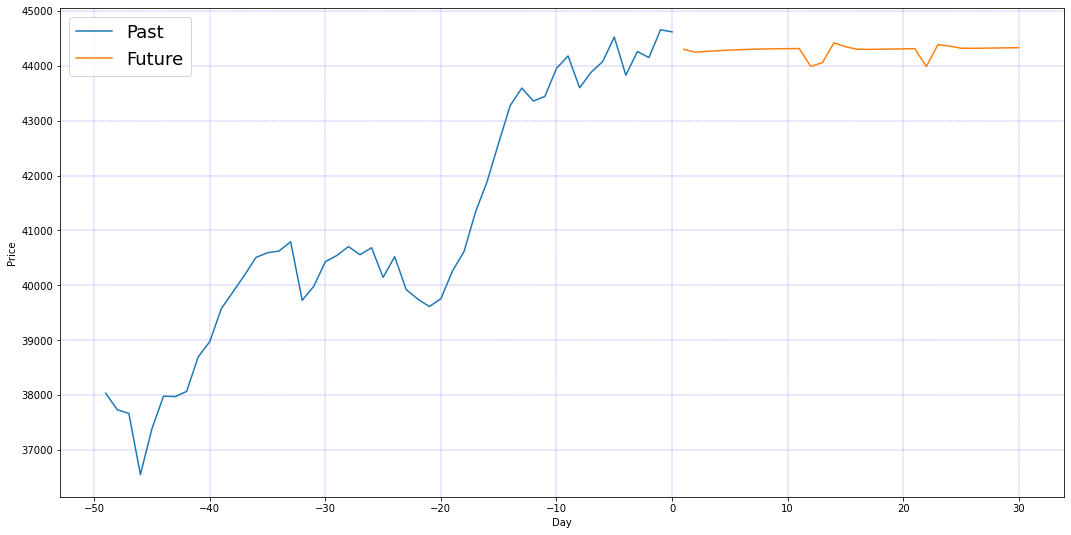

In [1602]:
plt.figure(figsize = (18,9))
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-time_step:]),label='Past')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Future')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xlabel('Day (0 means today)')
plt.ylabel('Price')
plt.legend(fontsize=18)
plt.show()

In [1603]:
print('Predicted stock price after 30 Days: ',scaler.inverse_transform(lst_output)[-1])

Predicted stock price after 30 Days:  [44330.04900371]


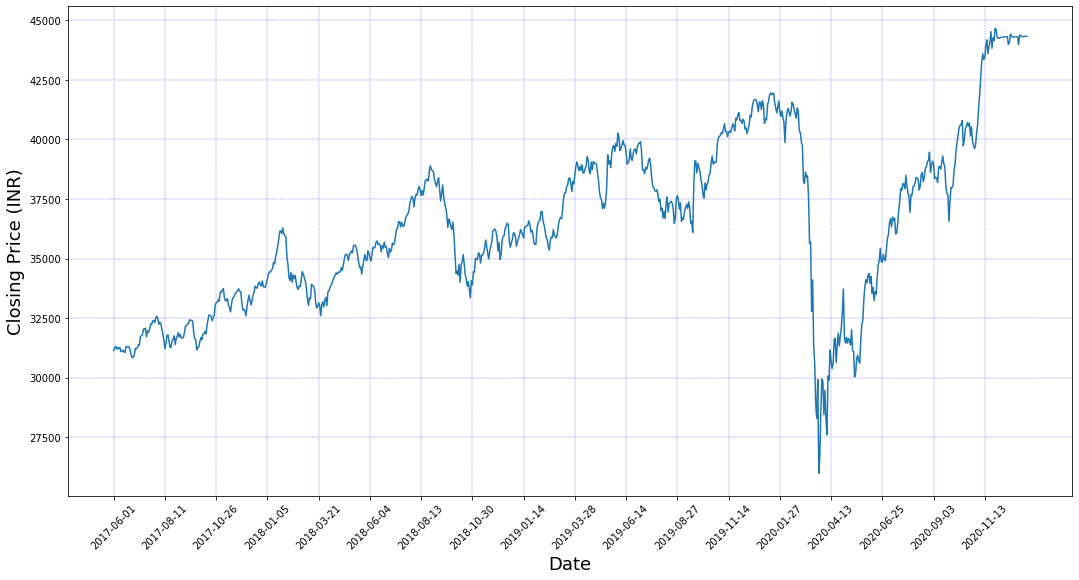

In [1605]:
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.figure(figsize = (18,9))
plt.plot(df3)
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price (INR)',fontsize=18)
plt.show()